Using device: cpu
Files already downloaded and verified
Training process for DCGAN:
╒═════════╤══════════════════╤══════════════════════╤═════════════╕
│   Epoch │   Generator Loss │   Discriminator Loss │   FID Score │
╞═════════╪══════════════════╪══════════════════════╪═════════════╡
│       1 │           6.1938 │               0.0399 │     723.141 │
├─────────┼──────────────────┼──────────────────────┼─────────────┤
│       2 │           5.821  │               0.0158 │     466.938 │
├─────────┼──────────────────┼──────────────────────┼─────────────┤
│       3 │           6.7831 │               0.0067 │     540.401 │
├─────────┼──────────────────┼──────────────────────┼─────────────┤
│       4 │           6.7997 │               0.0044 │     526.488 │
├─────────┼──────────────────┼──────────────────────┼─────────────┤
│       5 │           7.0659 │               0.009  │     544.279 │
├─────────┼──────────────────┼──────────────────────┼─────────────┤
│       6 │           7.316  │  

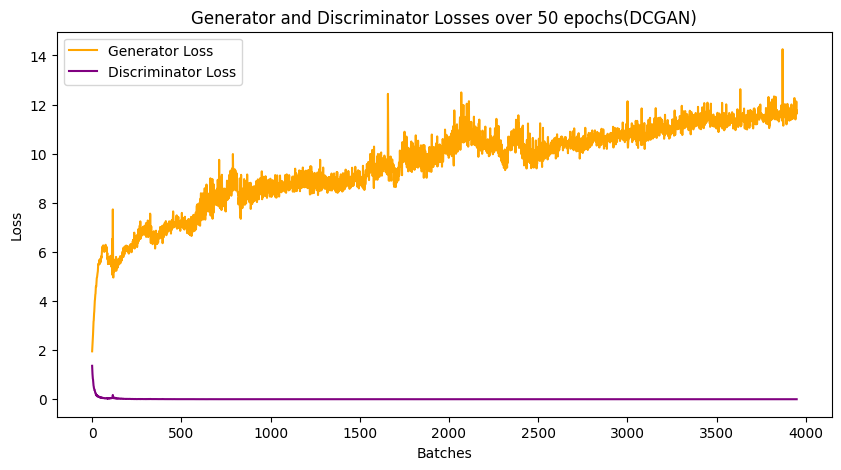

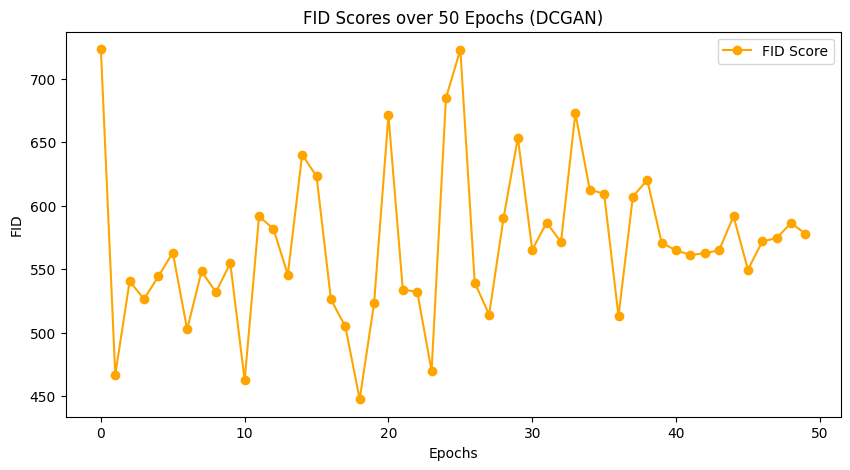

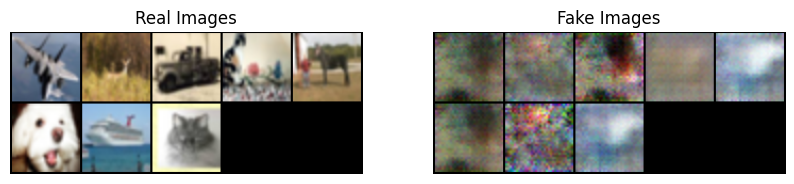

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader, Subset
from torchvision.transforms.functional import resize
from torchvision.models import Inception_V3_Weights
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.linalg import sqrtm
from torchvision.models import inception_v3

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
latent_vector_dim = 100
batch_size = 64
num_channels = 3
learning_rate = 2e-4
beta1 = 0.5
num_epochs = 50
subset_size = 5000  # Use a subset of the dataset
image_size = 64  # CIFAR-10 image size for training

# Dataset preparation
data_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

cifar10_data = datasets.CIFAR10(root='./cifar10_data', train=True, download=True, transform=data_transform)
cifar10_subset = Subset(cifar10_data, list(range(subset_size)))  # Use a subset for faster training
data_loader = DataLoader(cifar10_subset, batch_size=batch_size, shuffle=True, num_workers=2)


# Generator network
class ImageGenerator(nn.Module):
    def __init__(self, latent_dim, num_channels):
        super(ImageGenerator, self).__init__()
        self.generator_net = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, num_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.generator_net(x)


class ImageDiscriminator(nn.Module):
    def __init__(self, num_channels):
        super(ImageDiscriminator, self).__init__()
        self.discriminator_net = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 1, kernel_size=4, stride=2, padding=0, bias=False),
            nn.Sigmoid()  # Ensures output is in the range [0, 1]
        )

    def forward(self, x):
        # Pass through the network
        out = self.discriminator_net(x)  # Shape: [batch_size, 1, h, w]
        
        # Flatten spatial dimensions and channel dimension
        return out.view(out.size(0), -1).mean(dim=1)



# Initialize networks
gen_model = ImageGenerator(latent_vector_dim, num_channels).to(device)
disc_model = ImageDiscriminator(num_channels).to(device)

# Loss and optimizers
loss_fn = nn.BCELoss()
optimizer_gen = optim.Adam(gen_model.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_disc = optim.Adam(disc_model.parameters(), lr=learning_rate, betas=(beta1, 0.999))


# FID calculation helper
weights = Inception_V3_Weights.IMAGENET1K_V1  # Explicitly specify the weights
inception_model = inception_v3(weights=weights, transform_input=False).to(device)
inception_model.fc = nn.Identity()  # Remove fully connected layer
inception_model.eval()



def calculate_fid(real_images, fake_images):
    real_images = torch.nn.functional.interpolate(real_images, size=(256, 256), mode='bilinear', align_corners=False)
    fake_images = torch.nn.functional.interpolate(fake_images, size=(256, 256), mode='bilinear', align_corners=False)
    
    real_features = inception_model(real_images).detach().cpu().numpy()
    fake_features = inception_model(fake_images).detach().cpu().numpy()

    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    diff = np.sum((mu_real - mu_fake) ** 2)
    cov_mean = sqrtm(sigma_real @ sigma_fake)
    if np.iscomplexobj(cov_mean):
        cov_mean = cov_mean.real
    return diff + np.trace(sigma_real + sigma_fake - 2 * cov_mean)

# Helper function to save resized grids

def save_grids(real_images, fake_images, epoch, output_dir, resize_dims=(64, 64)):

    # Resize fake images to match real images
    fake_images_resized = torch.nn.functional.interpolate(fake_images, size=resize_dims, mode='bilinear', align_corners=False)

    # Create grids with consistent layout
    num_images = min(len(real_images), len(fake_images_resized))
    real_grid = make_grid(real_images[:num_images], nrow=5, normalize=True)
    fake_grid = make_grid(fake_images_resized[:num_images], nrow=5, normalize=True)

    # Save the grids
    save_image(real_grid, os.path.join(output_dir, f"real_grid_epoch_{epoch}.png"))
    save_image(fake_grid, os.path.join(output_dir, f"fake_grid_epoch_{epoch}.png"))


# Training loop
gen_losses, disc_losses, fid_scores = [], [], []
fixed_noise = torch.randn(32, latent_vector_dim, 1, 1, device=device)

outputs_dcgan_dir = "./outputs_dcgan"
os.makedirs(outputs_dcgan_dir, exist_ok=True)


from tabulate import tabulate

# Initialize a list to store results for tabular display
results = []

print("Training process for DCGAN:")



for epoch in range(num_epochs):
    for batch_idx, (real_imgs, _) in enumerate(data_loader):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Create labels
        real_labels = torch.ones(batch_size, device=device)
        fake_labels = torch.zeros(batch_size, device=device)

        # Train discriminator
        disc_model.zero_grad()
        noise = torch.randn(batch_size, latent_vector_dim, 1, 1, device=device)
        fake_imgs = gen_model(noise)
        real_loss = loss_fn(disc_model(real_imgs), real_labels)
        fake_loss = loss_fn(disc_model(fake_imgs.detach()), fake_labels)
        disc_loss = real_loss + fake_loss
        disc_loss.backward()
        optimizer_disc.step()

        # Train generator
        gen_model.zero_grad()
        fake_loss_gen = loss_fn(disc_model(fake_imgs), real_labels)
        fake_loss_gen.backward()
        optimizer_gen.step()

        # Record losses
        gen_losses.append(fake_loss_gen.item())
        disc_losses.append(disc_loss.item())

    # Calculate FID score
    with torch.no_grad():
        fid_score = calculate_fid(real_imgs[:batch_size], fake_imgs[:batch_size])
        fid_scores.append(fid_score)

    # Save resized grids
    save_grids(real_imgs, fake_imgs, epoch + 1, outputs_dcgan_dir)

    # Append results for the current epoch to the table
    results.append([epoch + 1, f"{gen_losses[-1]:.4f}", f"{disc_losses[-1]:.4f}", f"{fid_score:.4f}"])

# Print the complete table
print(tabulate(results, headers=["Epoch", "Generator Loss", "Discriminator Loss", "FID Score"], tablefmt="fancy_grid"))

# Save table to a file
table_file_path = os.path.join(outputs_dcgan_dir, "training_results.txt")
with open(table_file_path, "w") as f:
    f.write(tabulate(results, headers=["Epoch", "Generator Loss", "Critic Loss", "FID Score"], tablefmt="fancy_grid"))

print(f"Training results table saved to: {table_file_path}")


# Plot losses
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Losses over 50 epochs(DCGAN)")
plt.plot(gen_losses, label="Generator Loss", color="orange")
plt.plot(disc_losses, label="Discriminator Loss", color="purple")
plt.xlabel("Batches")
plt.ylabel("Loss")
plt.legend()
plt.savefig(os.path.join(outputs_dcgan_dir, "losses.png"))  # Use the correct directory variable here
plt.show()


# Plot FID scores with purple color
plt.figure(figsize=(10, 5))
plt.title("FID Scores over 50 Epochs (DCGAN)")
plt.plot(fid_scores, label="FID Score", marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.legend()
plt.savefig(os.path.join(outputs_dcgan_dir, "fid_scores.png"))  
plt.show()



# After the training loop and printing the table
# Display the saved grid for the last epoch
last_epoch = num_epochs  
real_image_path = os.path.join(outputs_dcgan_dir, f"real_grid_epoch_{last_epoch}.png")
fake_image_path = os.path.join(outputs_dcgan_dir, f"fake_grid_epoch_{last_epoch}.png")

# Load the saved images using PIL
real_images = Image.open(real_image_path)
fake_images = Image.open(fake_image_path)

# Plot the real and fake images side by side
plt.figure(figsize=(10, 5))

# Plot real images
plt.subplot(1, 2, 1)
plt.imshow(real_images)
plt.title("Real Images")
plt.axis('off')

# Plot fake images
plt.subplot(1, 2, 2)
plt.imshow(fake_images)
plt.title("Fake Images")
plt.axis('off')

plt.show()


In [2]:
!zip -r outputs_dcgan.zip outputs_dcgan

updating: outputs_dcgan/ (stored 0%)
updating: outputs_dcgan/.ipynb_checkpoints/ (stored 0%)
updating: outputs_dcgan/.ipynb_checkpoints/fake_grid_epoch_1-checkpoint.png (stored 0%)
updating: outputs_dcgan/.ipynb_checkpoints/fake_grid_epoch_11-checkpoint.png (deflated 0%)
updating: outputs_dcgan/.ipynb_checkpoints/fake_grid_epoch_12-checkpoint.png (deflated 0%)
updating: outputs_dcgan/.ipynb_checkpoints/fake_grid_epoch_13-checkpoint.png (deflated 0%)
updating: outputs_dcgan/.ipynb_checkpoints/fake_grid_epoch_14-checkpoint.png (deflated 0%)
updating: outputs_dcgan/.ipynb_checkpoints/fake_grid_epoch_15-checkpoint.png (deflated 0%)
updating: outputs_dcgan/.ipynb_checkpoints/fake_grid_epoch_16-checkpoint.png (deflated 0%)
updating: outputs_dcgan/.ipynb_checkpoints/fake_grid_epoch_17-checkpoint.png (deflated 0%)
updating: outputs_dcgan/.ipynb_checkpoints/fake_grid_epoch_18-checkpoint.png (deflated 0%)
updating: outputs_dcgan/.ipynb_checkpoints/fake_grid_epoch_19-checkpoint.png (deflated 0%)
